## HOG Features

The Histogram of Gradients is a straightforward feature extraction procedure that was developed in the context of identifying pedestrians within images.
HOG involves the following steps:

1. Optionally pre-normalize images. This leads to features that resist dependence on variations in illumination. (64x128 Image)
<img src = "https://cdn.analyticsvidhya.com/wp-content/uploads/2019/08/index_6.png" width=300 height=300 >

2. Convolve the image with two filters that are sensitive to horizontal and vertical brightness gradients. These capture edge, contour, and texture information.

<img src = "https://cdn.analyticsvidhya.com/wp-content/uploads/2019/08/Screenshot-from-2019-08-14-16-26-03.png" width=300 height=300>
<img src = "https://cdn.analyticsvidhya.com/wp-content/uploads/2019/08/article-image-3.png" width=300 height=300>
<img src = "https://cdn.analyticsvidhya.com/wp-content/uploads/2019/08/Article-image-4.png" width=300 height=300>


* Change in X direction(Gx) = 89 – 78 = 11
* Change in Y direction(Gy) = 68 – 56 = 8

* Total Gradient Magnitude =  √[(Gx)^2+(Gy)^2]

* Total Gradient Magnitude =  √[(11)^2+(8)^2] = 13.6

* Orientation : Φ = atan(Gy / Gx) = 36

3. Subdivide the image into cells of a predetermined size(8x8), and compute a histogram of the gradient orientations within each cell(9x1).
<img src = "https://cdn.analyticsvidhya.com/wp-content/uploads/2019/08/Screenshot-from-2019-08-14-16-07-46-e1566287832460.png"  width=150 hieght=150>
<img src = "https://cdn.analyticsvidhya.com/wp-content/uploads/2019/08/article-image-141.png">

4. Normalize the histograms in each cell by comparing to the block of neighboring cells. This further suppresses the effect of illumination across the image(36x1).
<img src = "https://cdn.analyticsvidhya.com/wp-content/uploads/2019/08/article-image-7.png"  width=400 hieght=400>

* V = [a1, a2, a3, ….a36]

* k = √(a1)2+ (a2)2+ (a3)2+ …. (a36)2

<img src = "https://cdn.analyticsvidhya.com/wp-content/uploads/2019/08/Screenshot-from-2019-08-19-18-24-37.png">

5. Construct a one-dimensional feature vector from the information in each cell.

<img src = "https://cdn.analyticsvidhya.com/wp-content/uploads/2019/08/article-image-8.png">

* Feature Vector Size : 105 x 36 x1 = 3780

A fast HOG extractor is built into the Scikit-Image project, and we can try it out relatively quickly and visualize the oriented gradients within each cell:

* ref code : https://github.com/scikit-image/scikit-image/blob/main/skimage/feature/_hog.py

* ref paper : https://hal.inria.fr/file/index/docid/548512/filename/hog_cvpr2005.pdf

* Original Image Shape : (300, 451, 3)
* Gray Image Shape : (300, 451)
* HOG Vectors Shape : (153090,)
* HOG Image Shape : (300, 451)


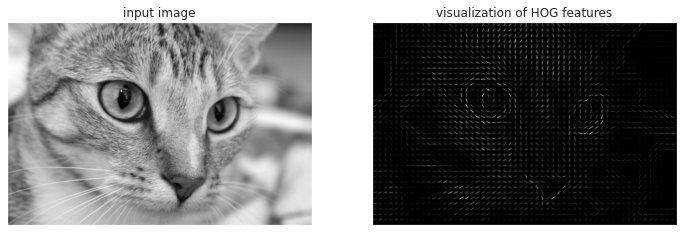

In [ ]:
# Load Sample Image
cat_image = data.chelsea()

print("* Original Image Shape : {}".format(cat_image.shape))

# Convert RGB to GRAY Image
image = color.rgb2gray(cat_image)
print("* Gray Image Shape : {}".format(image.shape))

# Get Histogram of Gradients
hog_vec, hog_vis = feature.hog(image, visualize=True)
print("* HOG Vectors Shape : {}".format(hog_vec.shape))
print("* HOG Image Shape : {}".format(hog_vis.shape))

# visualize HOG vector
fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis, cmap='gray')
ax[1].set_title('visualization of HOG features');

## HOG in Action: A Simple Face Detector

Using these HOG features, we can build up a simple facial detection algorithm with any Scikit-Learn estimator; here we will use a linear support vector machine (refer back to [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) if you need a refresher on this).
The steps are as follows:

1. Obtain a set of image thumbnails of faces to constitute "positive" training samples.
2. Obtain a set of image thumbnails of non-faces to constitute "negative" training samples.
3. Extract HOG features from these training samples.
4. Train a linear SVM classifier on these samples.
5. For an "unknown" image, pass a sliding window across the image, using the model to evaluate whether that window contains a face or not.
6. If detections overlap, combine them into a single window.

Let's go through these steps and try it out:

### 1. Obtain a set of positive training samples

Let's start by finding some positive training samples that show a variety of faces.
We have one easy set of data to work with—the Labeled Faces in the Wild dataset, which can be downloaded by Scikit-Learn:

* (n_sample, h, w) : (13233, 62, 47)


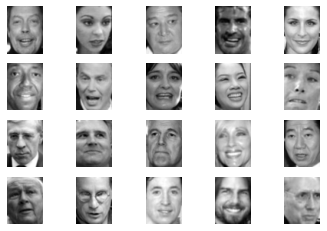

In [ ]:
from sklearn.datasets import fetch_lfw_people

# Load Labeled Faces in the Wild
faces = fetch_lfw_people()
positive_patches = faces.images

print("* (n_sample, h, w) : {}".format(positive_patches.shape))

# Visualize Positive Sample Patches
fig, ax = plt.subplots(4, 5)

for i, axi in enumerate(ax.flat):
    axi.imshow(positive_patches[500 * i], cmap='gray')
    axi.axis('off')

This gives us a sample of 13,000 face images to use for training.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

from skimage import data, color, feature

### 2. Obtain a set of negative training samples

Next we need a set of similarly sized thumbnails which *do not* have a face in them.
One way to do this is to take any corpus of input images, and extract thumbnails from them at a variety of scales.
Here we can use some of the images shipped with Scikit-Image, along with Scikit-Learn's ``PatchExtractor``:

In [ ]:
from skimage import data, transform

# Non Face Image Categories
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']

images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  if __name__ == '__main__':


In [ ]:
from sklearn.feature_extraction.image import PatchExtractor

# Extract patches in negative images
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])

print("* (n_sample, h, w) : {}".format(negative_patches.shape))

* (n_sample, h, w) : (30000, 62, 47)


We now have 30,000 suitable image patches which do not contain faces.
Let's take a look at a few of them to get an idea of what they look like:

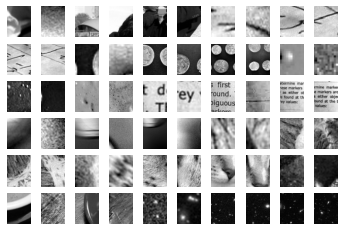

In [ ]:
# Visualize Negative Sample Patches
fig, ax = plt.subplots(6, 10)

for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

Our hope is that these would sufficiently cover the space of "non-faces" that our algorithm is likely to see.

### 3. Combine sets and extract HOG features

Now that we have these positive samples and negative samples, we can combine them and compute HOG features.
This step takes a little while, because the HOG features involve a nontrivial computation for each image:

In [ ]:
from itertools import chain

X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [ ]:
X_train.shape

(43233, 1215)

We are left with 43,000 training samples in 1,215 dimensions, and we now have our data in a form that we can feed into Scikit-Learn!

### 4. Training a support vector machine

Next we use the tools we have been exploring in this chapter to create a classifier of thumbnail patches.
For such a high-dimensional binary classification task, a Linear support vector machine is a good choice.
We will use Scikit-Learn's ``LinearSVC``, because in comparison to ``SVC`` it often has better scaling for large number of samples.

Let's try the support vector machine, with a grid search over a few choices of the C parameter:

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Grid Search to find the optimal parameter 'C'
# C : float, default=1.0
# Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
# Grid Search
grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

* When parameter 'C' is 1.0, The best accuracy is 0.9885272620319941


In [ ]:
print("* When parameter 'C' is {}, The best accuracy is {}%".format(grid.best_params_['C'],grid.best_score_*100))

* When parameter 'C' is 1.0, The best accuracy is 98.85272620319941%


In [ ]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC()

### 5. Find faces in a new image

Now that we have this model in place, let's grab a new image and see how the model does.
We will use one portion of the astronaut image for simplicity (see discussion of this in [Caveats and Improvements](#Caveats-and-Improvements)), and run a sliding window over it and evaluate each patch:

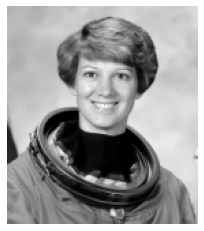

In [ ]:
test_image = data.astronaut()
test_image = color.rgb2gray(test_image)
test_image = transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

Next, let's create a window that iterates over patches of this image, and compute HOG features for each patch:

In [ ]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])

print("* patches_hog.shape : {}".format(patches_hog.shape))

* patches_hog.shape : (1911, 1215)


In [ ]:
labels = model.predict(patches_hog)
print("Number of Patches recognized as faces : {}".format(labels.sum()))

Number of Patches recognized as faces : 48.0


We see that out of nearly 2,000 patches, we have found 30 detections.
Let's use the information we have about these patches to show where they lie on our test image, drawing them as rectangles:

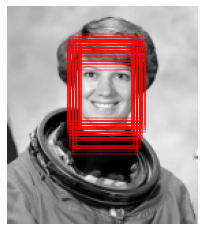

In [ ]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

All of the detected patches overlap and found the face in the image!
Not bad for a few lines of Python.